In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA

# Ayudantía 4: Matrices Ortogonales

## Proyecciones de Householder

Resumen del proceso:

Queremos crear una matriz ortogonal de forma más estable que usando el proceso de Gramm-Schmidt, que empieza a ser muy inestable ante columnas muy cercanas a ser L.D.

Para esto, usamos las proyecciones de householder, que insertan 0's en algunas entradas de la matriz.

Veremos un ejemplo de como realizar este procedimiento en una matriz de $5\times 5$.

$$A = \begin{pmatrix}
2&1&1&1&1\\
2&1&1&2&1\\
0&1&2&1&1\\
3&2&1&1&1\\
1&0&0&1&0
\end{pmatrix}$$

Primero, queremos armar una transformación $P_1$ sobre $A$ tal que:

$$P_1A = \begin{pmatrix}
x&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x\\
0&x&x&x&x
\end{pmatrix}$$

En este caso, podemos crearla como:

$$\tilde{u} = a_1 + \text{sign}(a_{11})\|a_1\|_2e_1 = \begin{pmatrix}2 + 3\sqrt{2}\\2\\0\\3\\1\end{pmatrix}$$

$$u = \frac{\tilde{u}}{\|\tilde{u}\|_2}$$

$$P_1 = I_5 - 2uu^T$$

[6.24264069 2.         0.         3.         1.        ]
[0.85773088 0.27479745 0.         0.41219618 0.13739873]


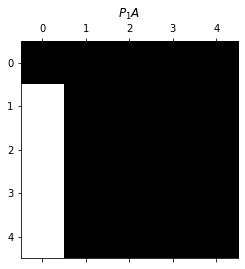

In [27]:
A = np.array([[2, 1, 1, 1, 1],
              [2, 1, 1, 2, 1],
              [0, 1, 2, 1, 1],
              [3, 2, 1, 1, 1],
              [1, 0, 0, 1, 0]], dtype=float)

I5 = np.eye(5)
e1 = I5[:,0]

u_tilde = A[:,0] + e1*np.linalg.norm(A[:,0])*np.sign(A[0,0])
print(u_tilde)

u = u_tilde/np.linalg.norm(u_tilde)
print(u)

P1 = I5 - 2*np.outer(u, u)

plt.spy(P1@A, precision=1e-14)
plt.title("$P_1A$")
plt.show()

#print(P1@A)

In [28]:
#A = LA.hilbert(100)
#b = np.ones(100)
#print(np.linalg.cond(A))

Aplicamos entonces el mismo proceso a la submatriz $A[2:5, 2:5]$, sin arruinar lo ya logrado. Esto es, aplicamos una matriz $P_2$ a $P_1A$ tal que:

$$P_2P_1A = \begin{pmatrix}
x&x&x&x&x\\
0&x&x&x&x\\
0&0&x&x&x\\
0&0&x&x&x\\
0&0&x&x&x
\end{pmatrix}$$

Para esto, $P_2$ debe ser como:

$$\begin{pmatrix}
1&0&0&0&0\\
0&y&y&y&y\\
0&y&y&y&y\\
0&y&y&y&y\\
0&y&y&y&y
\end{pmatrix}$$

donde la submatríz de $y$ se construye de manera análoga a la $P_1$. Veamos esto en código:

u:
 [-0.72898256  0.57069287  0.22070379 -0.30689398]
P2:
 [[ 1.          0.          0.          0.          0.        ]
 [ 0.         -0.06283115  0.83205029  0.32177843 -0.44744072]
 [ 0.          0.83205029  0.3486193  -0.25190816  0.35028441]
 [ 0.          0.32177843 -0.25190816  0.90257967  0.13546533]
 [ 0.         -0.44744072  0.35028441  0.13546533  0.81163217]]


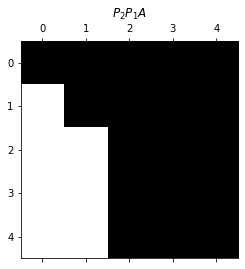

P2P1A:
 [[-4.24264069e+00 -2.35702260e+00 -1.64991582e+00 -2.35702260e+00
  -1.64991582e+00]
 [ 5.55111512e-17  1.20185043e+00  1.75655062e+00  3.69800131e-01
   9.24500327e-01]
 [-1.11022302e-16  1.11022302e-16  7.43096518e-01  1.43424286e+00
   3.94477214e-01]
 [-1.34874750e-16  0.00000000e+00 -7.59540786e-01 -4.45335917e-01
  -5.07632629e-01]
 [-2.22044605e-16 -2.77555756e-17  2.51422060e-01  2.28726119e-01
  -9.88623524e-02]]


In [9]:
B = P1@A #Guardandola en otra variable solo para efectos de visualización

I4 = np.eye(4)
e1 = I4[:,0]

u_tilde = B[1:,1] + e1*np.linalg.norm(B[1:,1])*np.sign(B[1,1])
u = u_tilde/np.linalg.norm(u_tilde)

print("u:\n", u)

P2_tilde = I4 - 2*np.outer(u, u)

P2 = np.eye(5)
P2[1:,1:] = P2_tilde

print("P2:\n", P2)

plt.spy(P2@P1@A, precision=1e-14)
plt.title("$P_2P_1A$")
plt.show()

print("P2P1A:\n",P2@P1@A)

Obviamente, podríamos hacer todo este proceso a mano, pero empieza a ser tedioso bastante rápido. Con esto, logramos construir una matriz triangular superior, a la que llamaremos $R$ como resultado de:

$$R = P_5P_4P_3P_2P_1A$$

Y la matriz ortogonal resultante corresponde a:

$$Q = (P_5P_4P_3P_2P_1)^{-1} = P_1^{-1}P_2^{-1}P_3^{-1}P_4^{-1}P_5^{-1} = P_1^{T}P_2^{T}P_3^{T}P_4^{T}P_5^{T}$$

Así, podemos lograr la descomposición QR de $A$ de forma más estable que con el algoritmo de GS. Revisemos el código de `HouseholderQR`

In [29]:
def HouseholderQR(A):
    """
    Una implementación ineficiente de HH-QR
    Input: A matriz de mxn, m >= n
    Output: (Q, R) matrices tales que A = QR
            Q: ortogonal de mxm
            R: triangular superior de mxn
    """
    
    m, n = A.shape
    R = np.copy(A)     # Buenas prácticas de código, nunca modificar el input
                       # Es preferible hacer una copia del input si queremos trabajar con él
    Q = np.identity(m)
    for k in range(n):
        
        x = R[k:,k]    # Tomamos la columna k de la submatriz de R que comienza en la fila k
        Lx = x.shape[0]
     
        v = x + np.sign(x[0])*np.linalg.norm(x, ord=2)*np.eye(1, M=Lx)[0] #armamos el vector u_tilde
        v = v/np.linalg.norm(v, ord=2) # armamos el vector u
        
        # Innecesario! Podemos hacer todo esto sin almacenar las matrices P!
        Pk = np.eye(Lx) - 2*np.outer(v,v)
        
        #Actualización A
        R[k:,k:] = Pk@R[k:,k:]
        
        #Vemos que se hace
        plt.spy(R, precision=1e-14)
        plt.show()
        
        #Actualización Q
        P = np.eye(m)
        P[k:,k:] = Pk
        Q = Q@P.T

    return Q, R

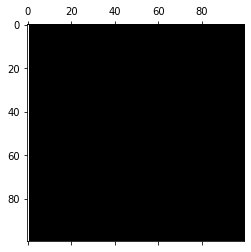

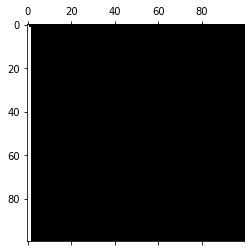

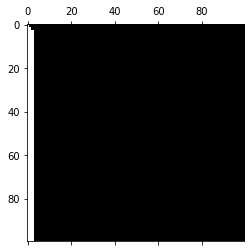

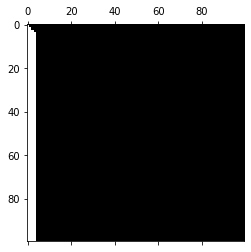

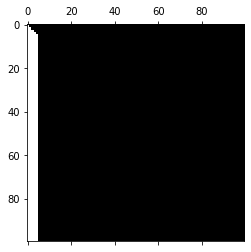

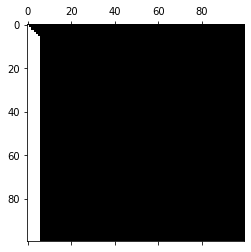

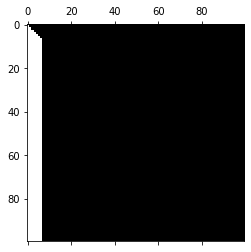

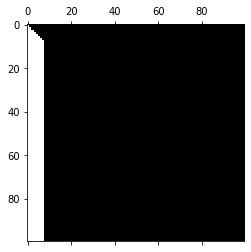

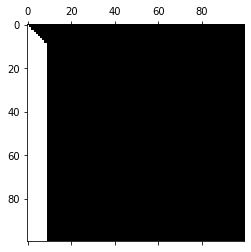

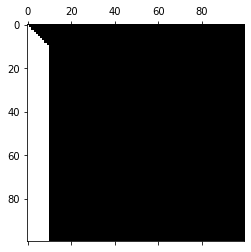

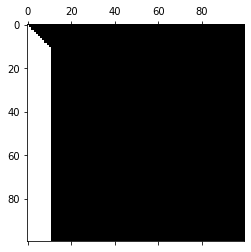

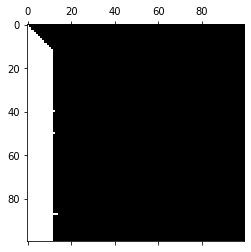

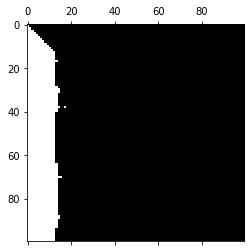

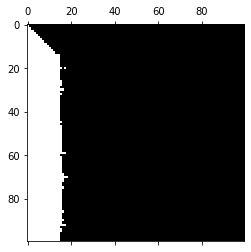

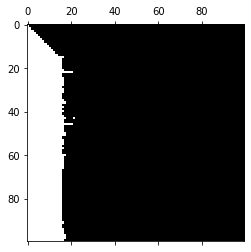

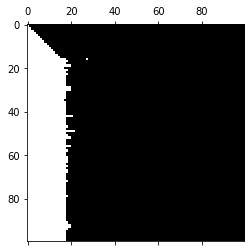

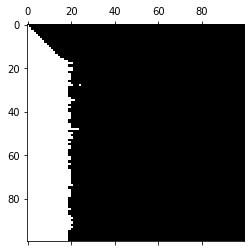

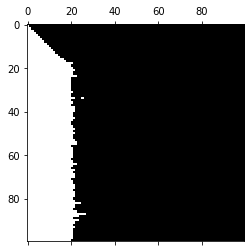

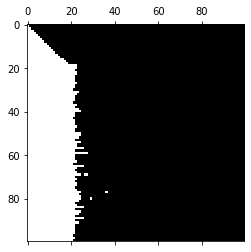

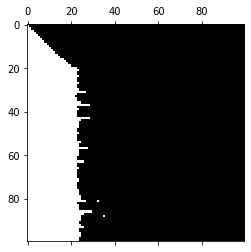

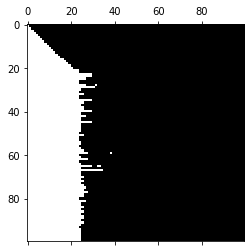

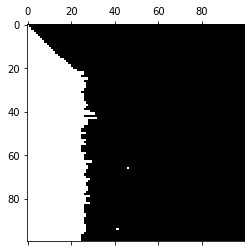

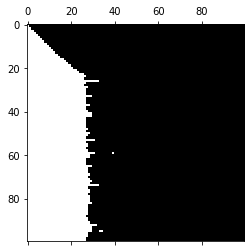

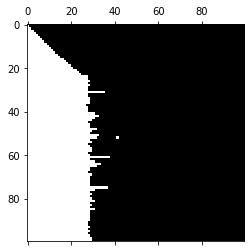

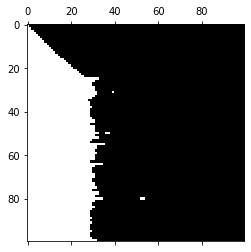

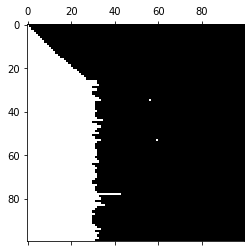

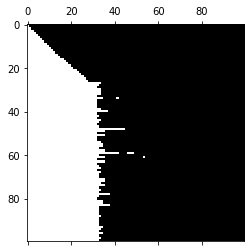

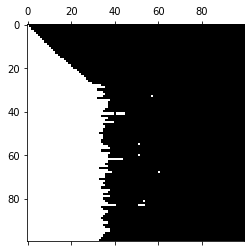

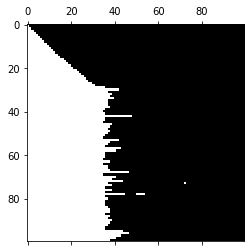

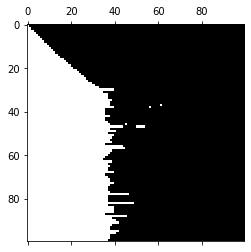

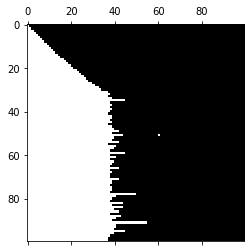

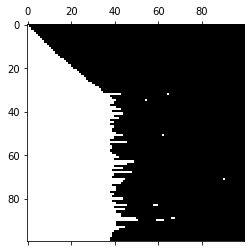

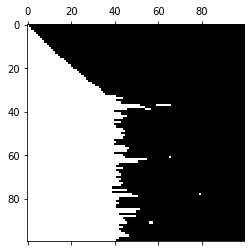

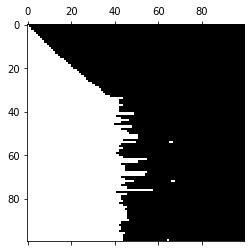

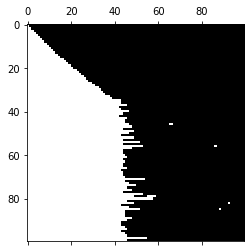

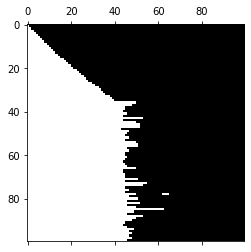

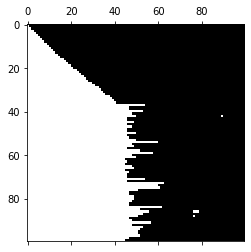

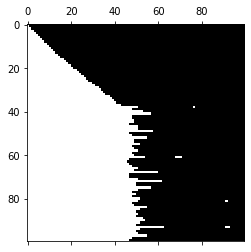

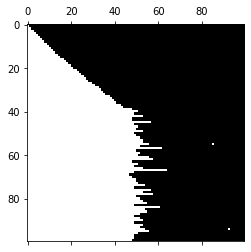

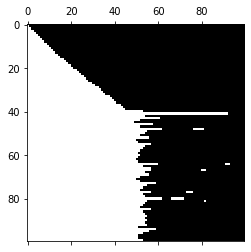

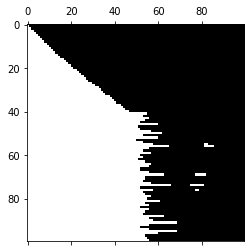

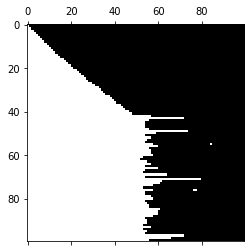

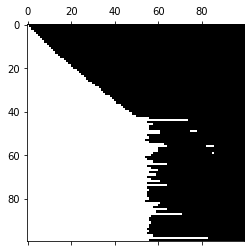

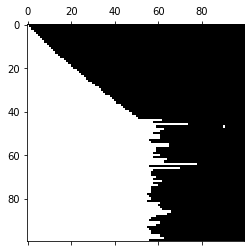

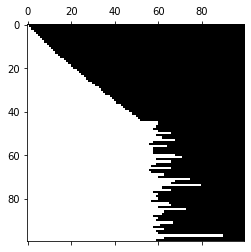

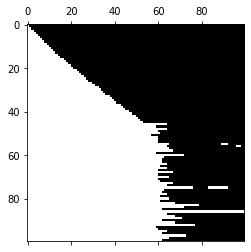

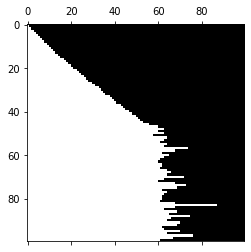

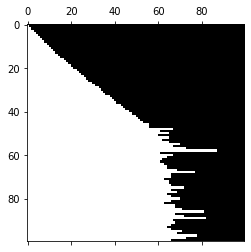

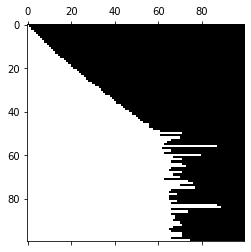

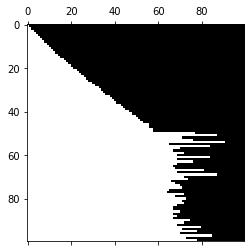

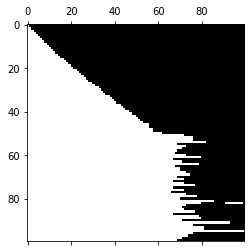

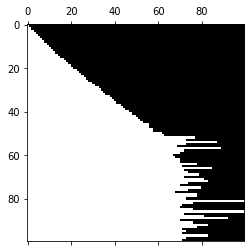

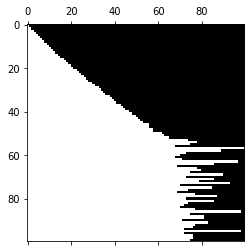

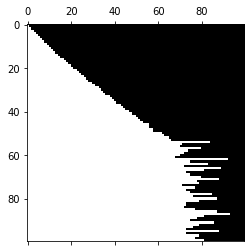

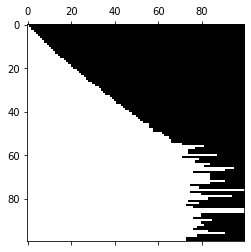

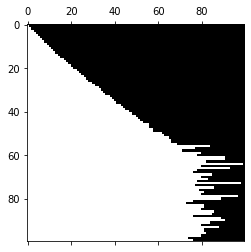

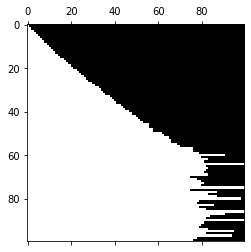

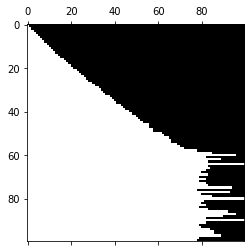

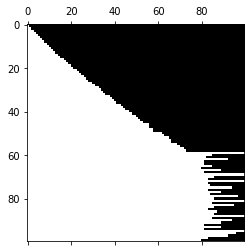

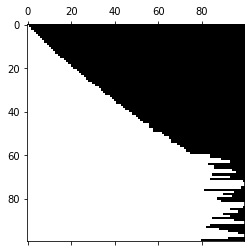

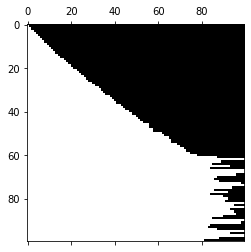

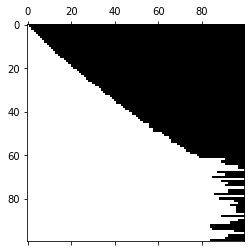

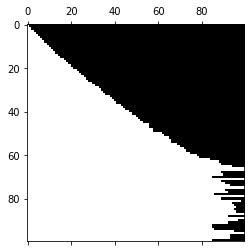

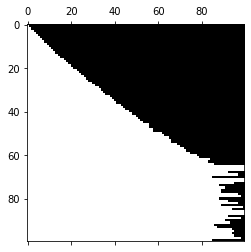

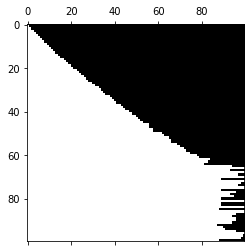

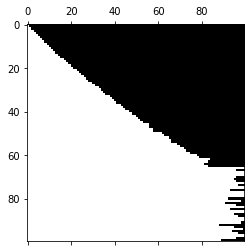

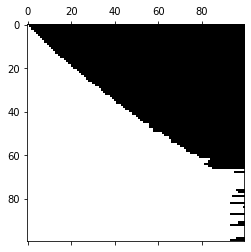

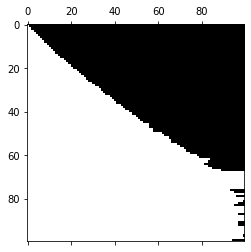

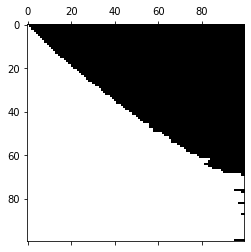

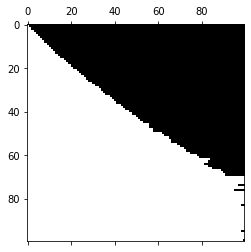

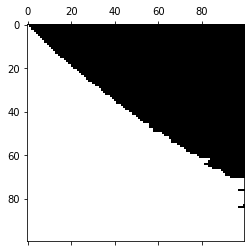

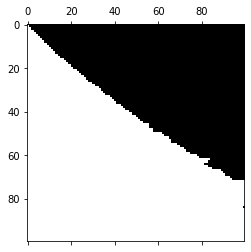

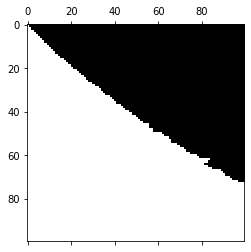

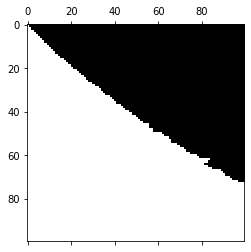

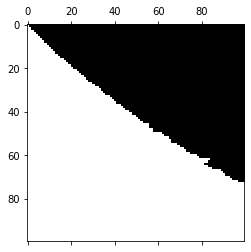

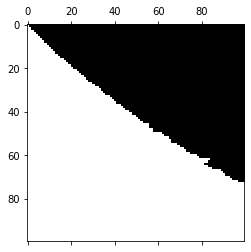

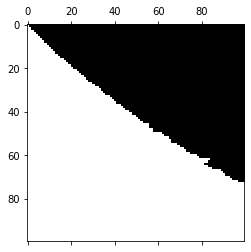

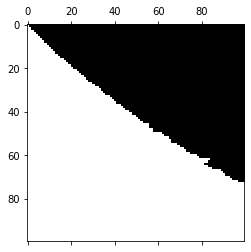

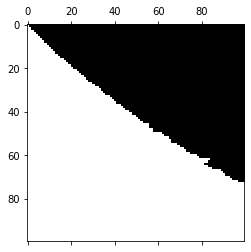

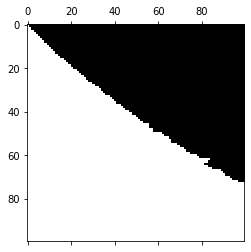

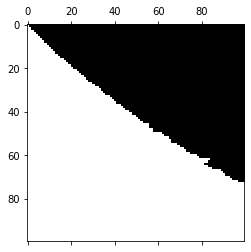

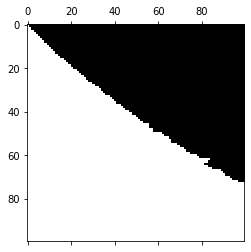

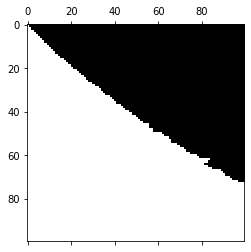

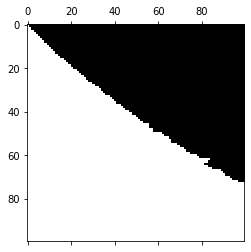

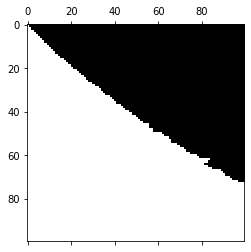

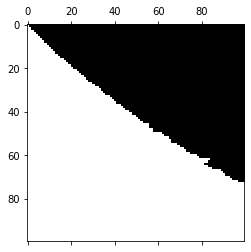

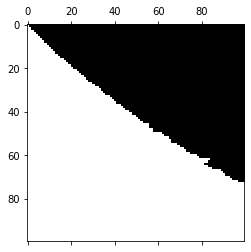

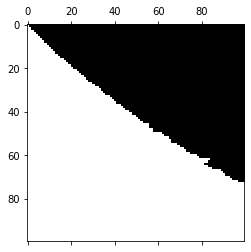

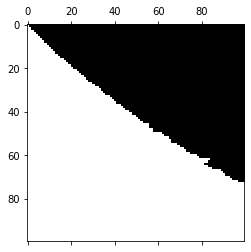

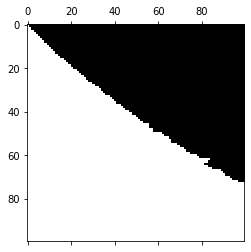

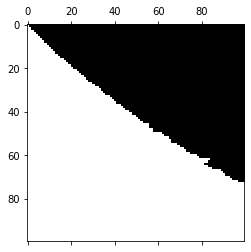

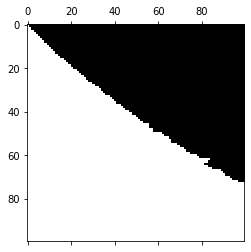

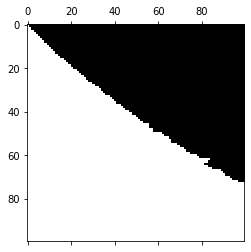

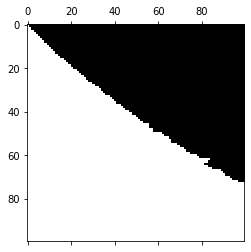

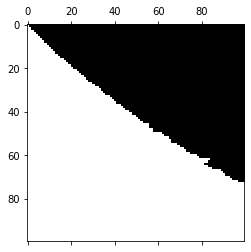

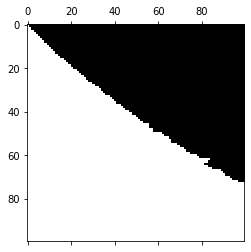

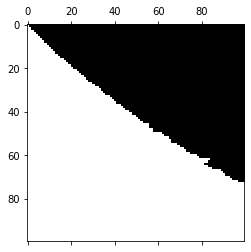

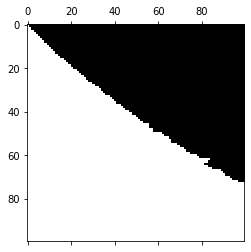

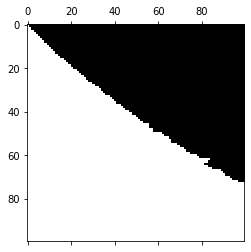

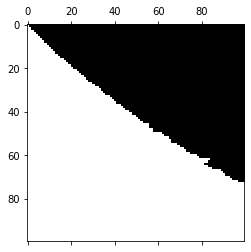

1.4757172910262806e-15


In [30]:
QH, RH = HouseholderQR(A)
print(np.linalg.norm(QH@RH - A))

## Rotaciones de Givens

En $\mathbb{R}^2$, podemos rotar un vector en un ángulo $\theta$ mediante la aplicación de la matriz:

$$R(\theta) = \begin{bmatrix}
\cos(\theta)&-\sin(\theta)\\
\sin(\theta)&\cos(\theta)
\end{bmatrix}$$

Para rotar las coordenadas $i, j$ de un vector en $\mathbb{R}^n$, basta con multiplicar este vector por la matriz:

$$R(\theta,i,j) = \begin{bmatrix}
1&&&&\\
&1&&&\\
&&\ddots&&\\
&&&\cos(\theta)&\dots&-\sin(\theta)\\
&&&\vdots&\ddots&\vdots&\\
&&&\sin(\theta)&\dots&\cos(\theta)\\
&&&&&&\ddots&\\
&&&&&&&1
\end{bmatrix}$$

Al contrario de Householder, usar este método en vez de llenar de 0's todos los elementos bajo la diagonal, se hace de manera 1 a 1, lo que tiene utilidad para casos donde es necesario llenar selectivamente entradas con 0's.

Podemos forzar a que la segunda componente sea 0 viendo que:

$$R(\theta)x = \begin{bmatrix}
\cos(\theta)&-\sin(\theta)\\
\sin(\theta)&\cos(\theta)
\end{bmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = 
\begin{pmatrix}
x_1\cos(\theta) - x_2\sin(\theta)\\
x_1\sin(\theta) + x_2\cos(\theta)
\end{pmatrix}$$

Así, buscamos $\theta$ tal que:

$$x_1\sin(\theta) + x_2\cos(\theta) = 0$$

Este valor de $\theta$ hace que:

$$\cos(\theta) = \frac{x_1}{\sqrt{x_1^2 + x_2^2}},\quad \sin(\theta) = -\frac{x_2}{\sqrt{x_1^2 + x_2^2}}$$

Teniendo una forma fácil de armar la matriz $R(\theta)$. Es obvio ver que para más dimensiones esto se intercambia por $x_1\to x_i$ y $x_2\to x_j$.

In [12]:
def givens(a, b):
    """
    Matrix Computations (Golub, Van Loan)
    Retorna matriz de rotación de 2x2 para entradas
    (a, b) = (x_i, x_j)
    """
    if b == 0:
        return np.identity(2)
    
    if abs(b)> abs(a):
        tau = -a/b
        s = 1/np.sqrt(1 + tau*tau)
        return np.array([[s*tau, -s], 
                         [s, s*tau]], dtype=float)
    tau = -b/a
    c = 1/np.sqrt(1 + tau*tau)
    return np.array([[c, -c*tau], [c*tau, c]], dtype=float)

In [14]:
x = np.array([np.sqrt(2), np.sqrt(3)])
R = givens(x[0], x[1])

print(x)
print(R@x)

[1.41421356 1.73205081]
[-2.23606798  0.        ]


Ahora, nos interesa saber como ocupar esta herramienta para generar matrices ortogonales, como la de la factorización QR. Veremos el caso de como hacer GivensQR en el siguiente código:

In [15]:
def GivensQR(A):
    """
    Factorización QR de A por rotaciones de Givens
    input: A de mxn, m >= n.
    output: Q, R. Q de mxm, R de mxn
    """
    m, n = A.shape
    R = np.copy(A)
    Q = np.identity(m)
    for j in range(n):
        for i in np.arange(m-1, j, -1):
            
            x1, x2 = R[i-1, j], R[i, j] 
            R_theta = givens(x1, x2)
            
            R[i-1:i+1, j:] = R_theta@R[i-1:i+1, j:]
            
            #Visualizamos que está haciendo el algoritmo a la matriz A:
            plt.spy(R, precision=1e-14)
            plt.show()
            
            #Obtenemos Q
            R_theta_full = np.identity(m)
            R_theta_full[i-1:i+1, i-1:i+1] = R_theta
            
            Q = Q@R_theta_full.T
            
    return Q, R

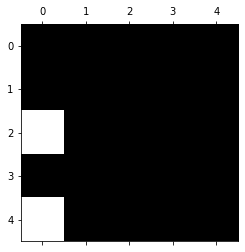

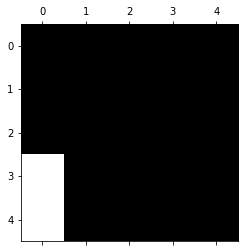

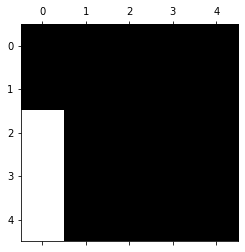

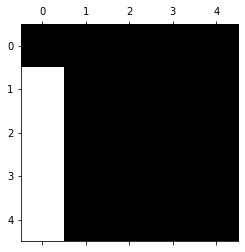

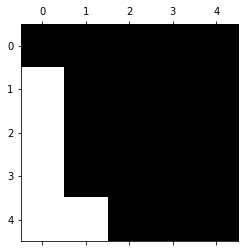

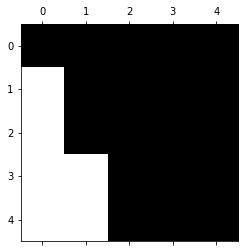

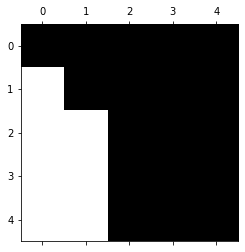

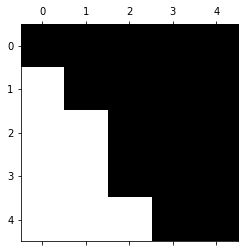

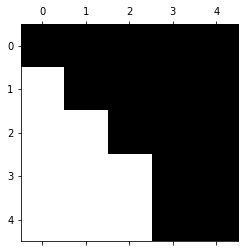

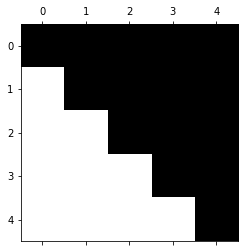

1.0592403030067776e-15


In [16]:
Q, R = GivensQR(A)
print(np.linalg.norm(Q@R-A))

## Minimos cuadrados de rango deficiente usando SVD

Hay veces donde al querer resolver un problema, este está muy mal condicionado dado que la matriz que representa al sistema no tiene rango completo (afirmación necesaria para resolver mínimos cuadrados de manera usual por ejemplo).

<b>Proposición 3.1(Demmel):</b> Sea $A\in \mathbb{R}^{m\times n}$ con $m\geq n$ de rango $A=r<n$. Entonces existe un conjunto de dimensión $n-r$ de vectores que minimiza $\|Ax-b\|_2$.

Con esto, una forma de regularizar este problema 'mal puesto' es mediante el uso del siguiente teorema:

<b>Teorema (Demmel):</b> Cuando $A$ de $m\times n$ de rango $r<n$ es. singular, el $x$ que minimiza $\|Ax-b\|_2$ se puede caracterizar como sigue. Para esto, $A=U\Sigma V^T$ es su descomposición SVD y la escribimos como:

$$A = \begin{bmatrix}U_1&U_2\end{bmatrix}\begin{bmatrix}\Sigma_1&0\\0&0\end{bmatrix}\begin{bmatrix}V_1^T\\V^T_2\end{bmatrix}$$

donde $\Sigma_1$ de $r\times r$ almacena los valores singulares no 0. Sea también $\sigma = \sigma_{min}(\Sigma_1)$. Entonces:

- Las soluciones al problema se pueden escribir como siguen, para un $z$ arbitrario:

$$x = V_1\Sigma_1^{-1}U_1^Tb + V_2z$$

- El $x$ de norma mínima se obtiene haciendo $z=0$ y en este caso $\|x\|_2 \leq \|b\|_2/\sigma$

- Cambiando $b$ a $b+\delta b$ cambia la norma de la solución en a lo más $\|\delta b\|_2/\sigma$


### Ejemplo:

Tenemos una matriz que nos indica los efectos de una droga para $m$ pacientes, almacenando su sugar level inicial $a_{i,1}$, su sugar level final $b_i$, la cantidad de la droga administrada $a_{i,2}$ y el peso del paciente en cada día a lo largo de una semana $a_{i,3},\dots,a_{i,9}$ respectivamente.

Los pesos no varian mucho día a día, por lo que es altamente probable que algunas de estas columnas sean muy cercanas a ser L.D. Spdg, y para caso ilustrativo, crearemos una matriz que así lo sea en los dos primeros días.

In [24]:
A = np.zeros((9, 9), dtype=float)

A[:,0] = np.random.normal(loc=100, scale=30, size=9)
b = np.random.normal(loc=120, scale=30, size=9)

A[:,1] = 5*np.ones(9)

A[:,2] =  np.random.normal(loc=60, scale=20, size=9)
A[:,3] = A[:,2]

for i in range(4, 9):
    A[:,i] = A[:, 2] + np.random.normal(size=9)/1000

In [26]:
U, S, VT = np.linalg.svd(A)
print(S)

U1, U2 = U[:,:8], U[:,8]
S1 = S[:8]
V1T, V2T = VT[:8,:], VT[8,:]

x = V1T.T@np.linalg.inv(np.diag(S1))@U1.T@b
print(x)

1.1873144918727298e-13
[5.27808856e+02 8.56678444e+01 1.77348038e+00 4.55455333e-03
 2.39478238e-03 1.53979436e-03 9.74868286e-04 7.21843851e-04
 5.93401647e-17]
[-6.96969070e-01  3.66189915e+01 -2.38357518e+04 -2.38357518e+04
 -6.07331786e+03  3.28673687e+04 -4.28635865e+02 -1.24426081e+03
  2.25500197e+04]


Vemos que una de las principales dificultades de resolver el problema de mínimos cuadrados cuando hay rango deficiente es el mal condicionamiento del problema. Por ejemplo, sea $B, b$:

$$B = \begin{pmatrix}1&0&0\\0&0&0\\0&0&0\end{pmatrix},\quad b=\begin{pmatrix}1\\1\\1\end{pmatrix}$$

In [20]:
B = np.array([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]])
b = np.array([1., 1., 1.])

U, S, VT = np.linalg.svd(B)

U1, U2 = U[:,:1], U[:,1]
S1 = S[:1]
V1T, V2T = VT[:1,:], VT[1,:]

x = V1T.T@np.linalg.inv(np.diag(S1))@U1.T@b

print(f"La solución de mínimos cuadrados es: x = {x}")
print(f"La norma de la solución es: |x| = {np.linalg.norm(x)}")

La solución de mínimos cuadrados es: x = [1. 0. 0.]
La norma de la solución es: |x| = 1.0


Que pasa si perturbamos un poco la matriz $B$ por digamos $\delta B$:

$$B+\delta B = \begin{pmatrix}1&0&0\\0&\varepsilon&0\\0&0&0\end{pmatrix}$$

Entonces, tenemos como valores singulares $1, \varepsilon, 0$, y así:

In [21]:
eps = np.finfo(float).eps
B_tilde = np.array([[1., 0., 0.], [0., eps, 0.], [0., 0., 0.]])

U, S, VT = np.linalg.svd(B_tilde)
U1, U2 = U[:,:2], U[:,2]
S1 = S[:2]
V1T, V2T = VT[:2,:], VT[2,:]

x = V1T.T@np.linalg.inv(np.diag(S1))@U1.T@b

print(f"La solución de mínimos cuadrados es: x = {x}")
print(f"La norma de la solución es: |x| = {np.linalg.norm(x)}")

La solución de mínimos cuadrados es: x = [1.00000000e+00 4.50359963e+15 0.00000000e+00]
La norma de la solución es: |x| = 4503599627370496.0


Surge entonces la pregunta de, ¿cómo hacer que ante pequeñas perturbaciones no cambie tanto la solución?

En general, cada vez que computamos los valores singulares $\widehat{\sigma}_i$ de una matriz $A$, estos son tal que:

$$|\widehat{\sigma}_i - \sigma_{i}|\leq \mathcal{O}(\varepsilon)\|A\|_2$$

Como consecuencia de backward stability del cálculo de SVD. Con esto, cada valor singular computado tal que:

$$\widehat{\sigma}_i\leq \mathcal{O}(\varepsilon)\|A\|_2$$

Podemos tratarlo como 0. Así:

In [22]:
U, S, VT = np.linalg.svd(B_tilde)

B_norm = np.linalg.norm(B)

index = 0
for i in range(len(S)):
    if S[i] <= eps*B_norm:
        index = i
        break


U1, U2 = U[:,:index], U[:,index]
S1 = S[:index]
V1T, V2T = VT[:index,:], VT[index,:]

x = V1T.T@np.linalg.inv(np.diag(S1))@U1.T@b

print(f"La solución de mínimos cuadrados es: x = {x}")
print(f"La norma de la solución es: |x| = {np.linalg.norm(x)}")

La solución de mínimos cuadrados es: x = [1. 0. 0.]
La norma de la solución es: |x| = 1.0


## Comparación de algoritmos para Mínimos cuadrados

Si $A\in \mathbb{R}^{m\times n}, b\in\mathbb{R}^n$, entonces los algoritmos de Householder, Givens, y SVD para resolver mínimos cuadrados tienen los siguientes números de operaciones (flop count):


|Algoritmo | Flop count|
| --- | --- |
|Householder QR| $$n^3/3$$ |
|Givens QR| $$3mn^2-n^3$$ |
|SVD| $$4mn^2 + 8n^3$$ |


### Una telenovela de un minuto

https://www.youtube.com/watch?v=5NdAvBSbmNU